# Calculate and plot upper air data

## Setup

In [1]:
# Import statement
import xarray as xr
from typing import List
import cartopy.crs as ccrs
import numpy as np
import xskillscore as xs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib.patches as patches
from scipy.ndimage import gaussian_filter
import metpy.calc as mpcalc
from metpy.units import units
from xgcm import Grid


# Set default style to dark background because I like it better
plt.style.use("dark_background")
plt.rcParams["hatch.linewidth"] = 0.3


In [2]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def smooth(da: xr.DataArray, sigma: int = 3, axes: tuple = (1, 2)) -> xr.DataArray:
    """Apply Gaussian smoothing to the DataArray."""
    smoothed_da = da.copy()
    smoothed_da.values = gaussian_filter(da.values, sigma=sigma, axes=axes)
    smoothed_da = smoothed_da.assign_attrs(da.attrs)
    return smoothed_da


def get_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Return a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [w[varname].sel(time=slice(start_time, end_time)) for w in wofs_list],
        dim=init_dim,
    ).chunk({"init": -1})


def calc_theta(temp: xr.DataArray, pres: int) -> xr.DataArray:
    theta = (temp + 273.15) * (1000 / pres) ** 0.286
    return theta


def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


In [3]:
# Load in 20-23Z initializations
wofs_all = [get_wofs_all(i) for i in [20,21,22,23]]

In [4]:
# Define variables and parameters
lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Get coarse lat/lon
coarse_lat = wofs_all[0].xlat_snd.isel(time=0).squeeze().drop_vars("time")
coarse_lon = wofs_all[0].xlon_snd.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

# Create a DataArray for the initialization dimension
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init").assign_coords(
    {"init": ["20Z", "21Z", "22Z", "23Z"]}
)

## Calculate U, V, and Z at 300mb

In [5]:
# Read in pressure, height above ground level, elevation, and winds
p = get_field(wofs_all, "p", "2021-09-01 23:00:00", "2021-09-02 02:00:00", init)
z_agl = get_field(wofs_all, "z_agl", "2021-09-01 23:00:00", "2021-09-02 02:00:00", init)
hgt_snd = get_field(
    wofs_all, "hgt_snd", "2021-09-01 23:00:00", "2021-09-02 02:00:00", init
)
u = get_field(wofs_all, "u", "2021-09-01 23:00:00", "2021-09-02 02:00:00", init)
v = get_field(wofs_all, "v", "2021-09-01 23:00:00", "2021-09-02 02:00:00", init)

# Rename hgt_snd dimensinos to match that of z_agl
hgt_snd = hgt_snd.rename({"dim_1": "ny", "dim_0": "nx"})

# Add the elevation to the height above ground level yielding height with respect to sea level
z = z_agl + hgt_snd

# Regrid using xgcm to pressure levels
ds = xr.merge([z.rename("z"), p.rename("pres"), u.rename("u"), v.rename("v")])
grid = Grid(ds, coords={"Z": {"center": "nz"}}, periodic=False)
target_p = np.array([700, 500, 300, 200])
gz = grid.transform(ds.z, "Z", target_p, target_data=ds.pres, method="log").rename(
    "geo_hgt"
)
u_pres = grid.transform(ds.u, "Z", target_p, target_data=ds.pres, method="linear")
v_pres = grid.transform(ds.v, "Z", target_p, target_data=ds.pres, method="linear")


/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/janoski/miniforge3/envs/wof/lib/python3.12/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


## 01 to 02 UTC rainfall

In [6]:
# Get the 01 to 02 UTC rainfall
rain12 = get_total_field(
    wofs_all, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
)
# rain01 = get_total_field(wofs_all, "rain", "2021-09-02 00:05:00", "2021-09-02 01:00:00", init_dim=init)

# Calculate standard deviation of rainfall
std = rain12.std(dim=("init", "ne"))

# Lastly, make our area of interest where sd > 65% of max sd
aoi = std > (std.max() * 0.65)

rain12_aoi = rain12.where(aoi).mean(dim=("lat", "lon"), skipna=True)

## Calculate and plot correlations

### Z300

In [8]:
raw_sens_Z300 = xs.linslope(gz.sel(pres=300), rain12_aoi, dim=("ne", "init")).load()
stan_sens_Z300 = raw_sens_Z300 * gz.sel(pres=300).std(dim=("ne", "init"))
pval_Z300 = xs.pearson_r_p_value(
    gz.sel(pres=300), rain12_aoi, dim=["ne", "init"]
).load()


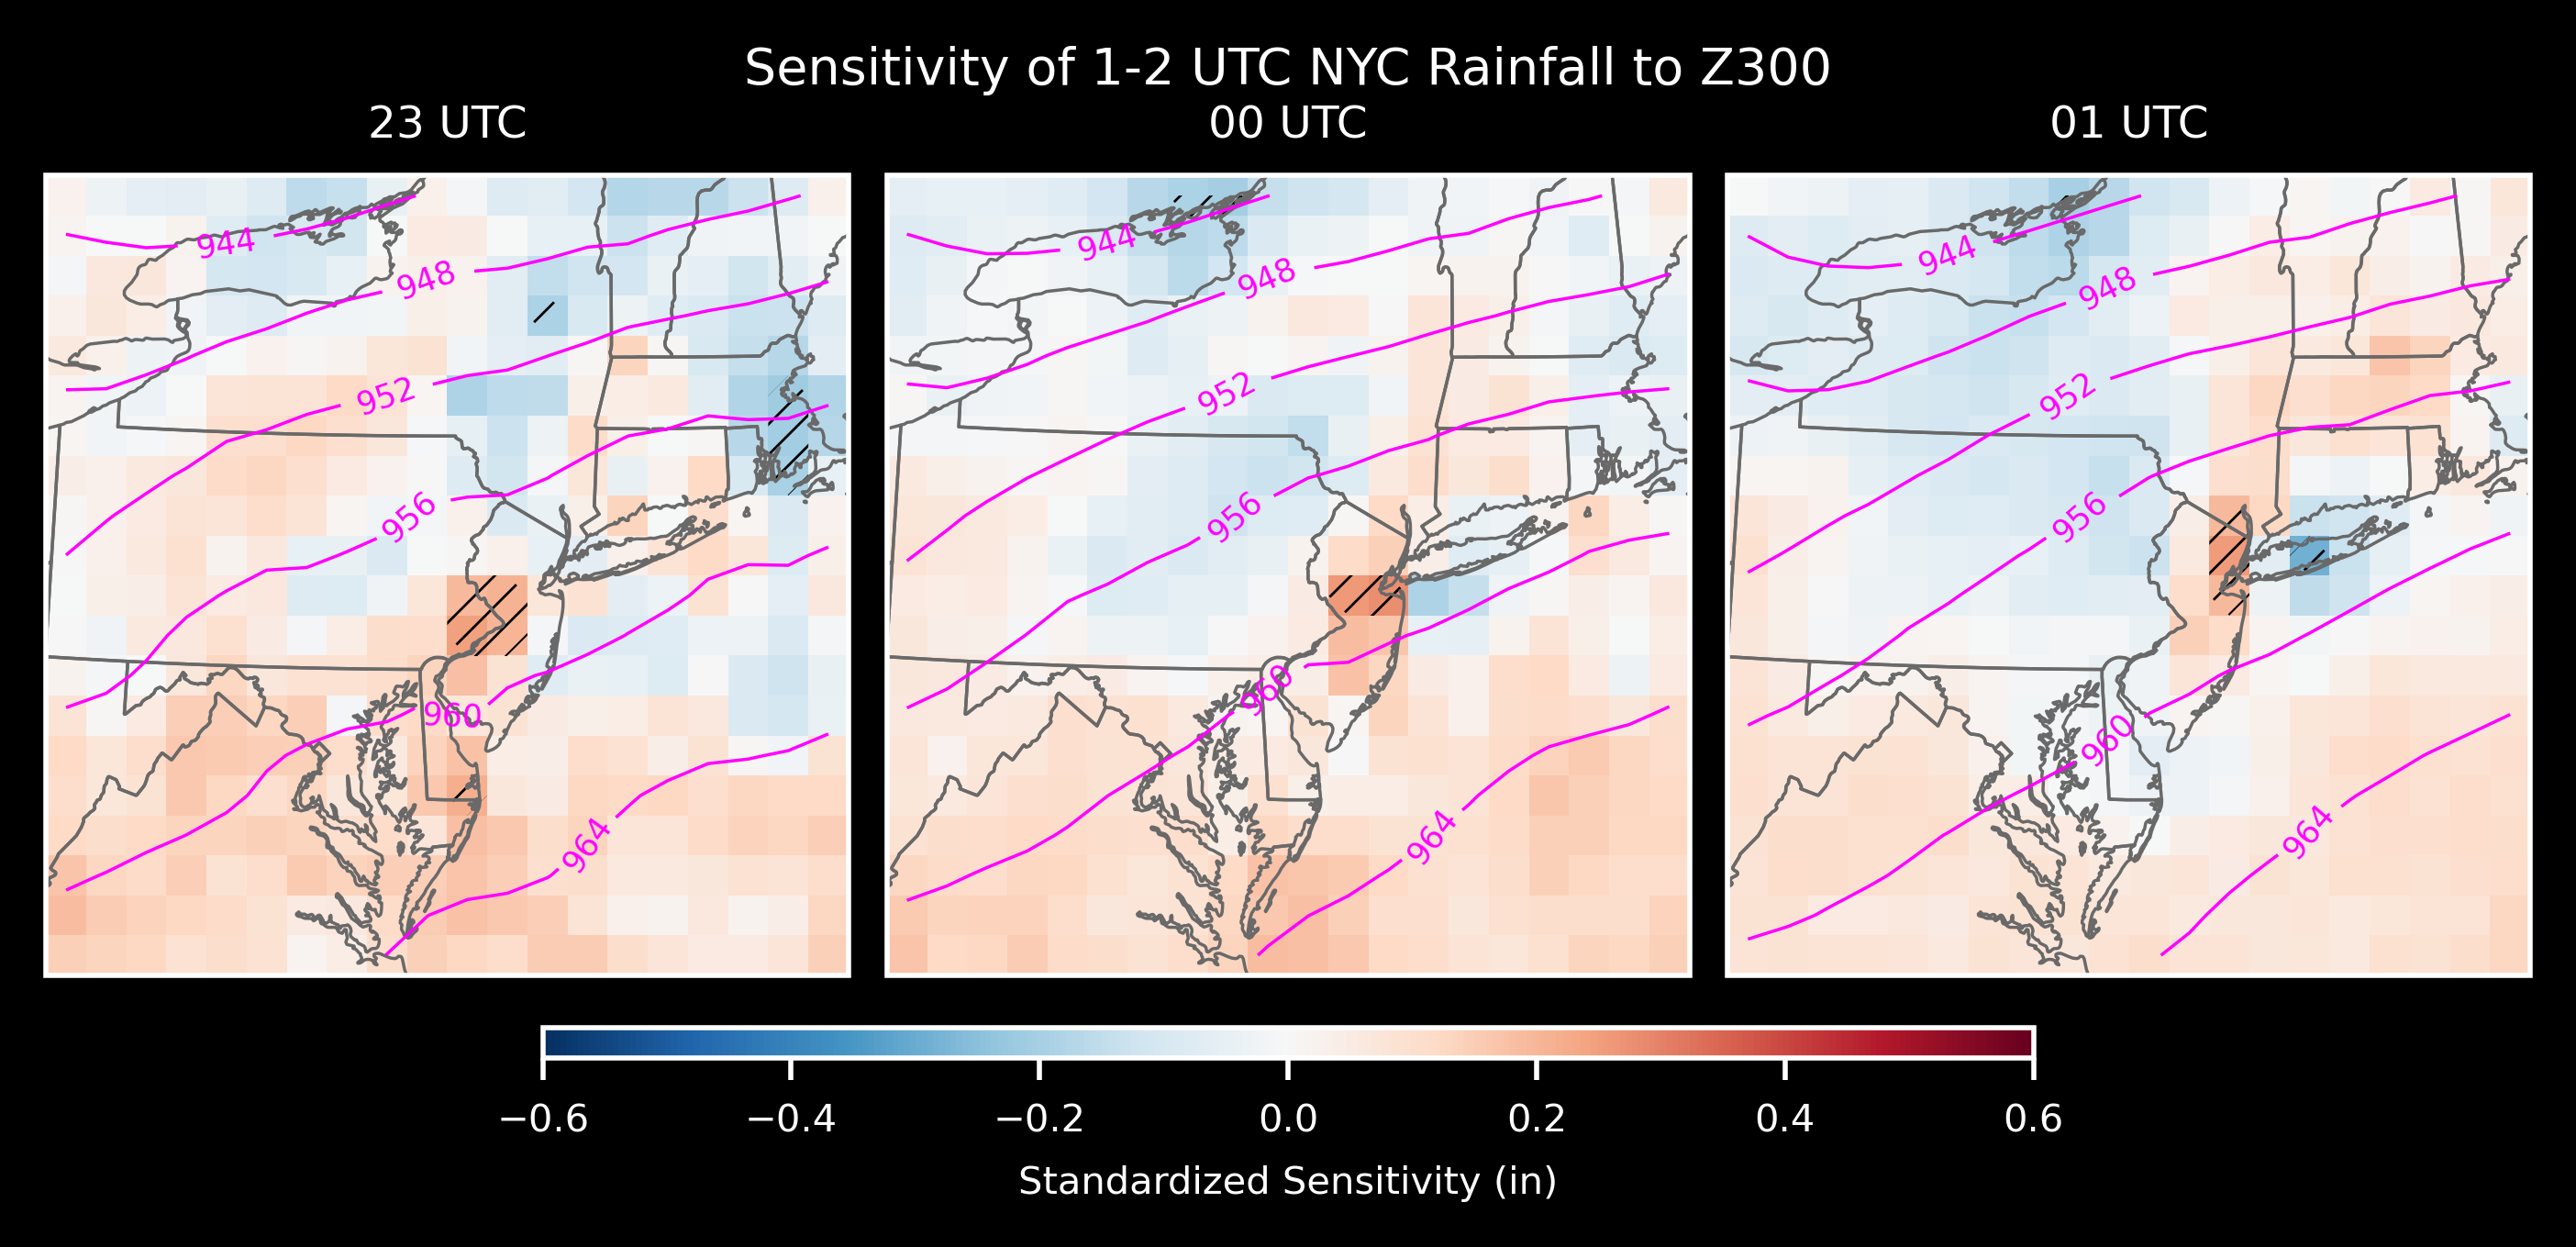

In [9]:
times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00", "2021-09-02 01:00:00"]
plt.rcParams["hatch.linewidth"] = 0.4
# Get data to plot
means = [gz.sel(time=t, pres=300).mean(dim=("ne", "init")).squeeze() for t in times]
data = [stan_sens_Z300.sel(time=t).squeeze() for t in times]
pdata = [pval_Z300.sel(time=t).squeeze() for t in times]
titles = ["23 UTC", "00 UTC", "01 UTC"]

# Increase the figure height to make more room vertically
fig, axes = plt.subplots(
    1,
    len(times),
    figsize=(5.5, 2.5),  # Increased height from 3 to 4
    dpi=500,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Adjust the suptitle position to be higher up
fig.suptitle(
    "Sensitivity of 1-2 UTC NYC Rainfall to Z300",
    fontsize=8,
    y=1.02,
)

# Plot spatial correlation
for i, ax in enumerate(axes):
    pc = ax.pcolormesh(
        coarse_lon,
        coarse_lat,
        data[i],  # .where(abs(pdata[i])<0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.6,
        vmax=0.6,
    )

    c = ax.contourf(
        coarse_lon,
        coarse_lat,
        (abs(pdata[i]) < 0.025),
        levels=[0, 0.5, 1],
        colors="none",
        hatches=("", "/////"),
        zorder=2,
        transform=ccrs.PlateCarree(),
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="dimgray", zorder=2)

    ax.set_title(titles[i], fontsize=7)

    # Add contours of the ensemble mean Z300
    c = ax.contour(
        coarse_lon,
        coarse_lat,
        means[i] / 10,
        zorder=3,
        transform=ccrs.PlateCarree(),
        linewidths=0.5,
        colors="magenta",
    )
    ax.clabel(c, inline=True, fontsize=5)


# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.05,
    aspect=50,
    shrink=0.6,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"Standardized Sensitivity (in)", fontsize=6)

plt.show()


### Z500

In [14]:
raw_sens_Z500 = xs.linslope(gz.sel(pres=500), rain12_aoi, dim=("ne", "init")).load()
stan_sens_Z500 = raw_sens_Z500 * gz.sel(pres=500).std(dim=("ne", "init"))
pval_Z500 = xs.pearson_r_p_value(
    gz.sel(pres=500), rain12_aoi, dim=["ne", "init"]
).load()


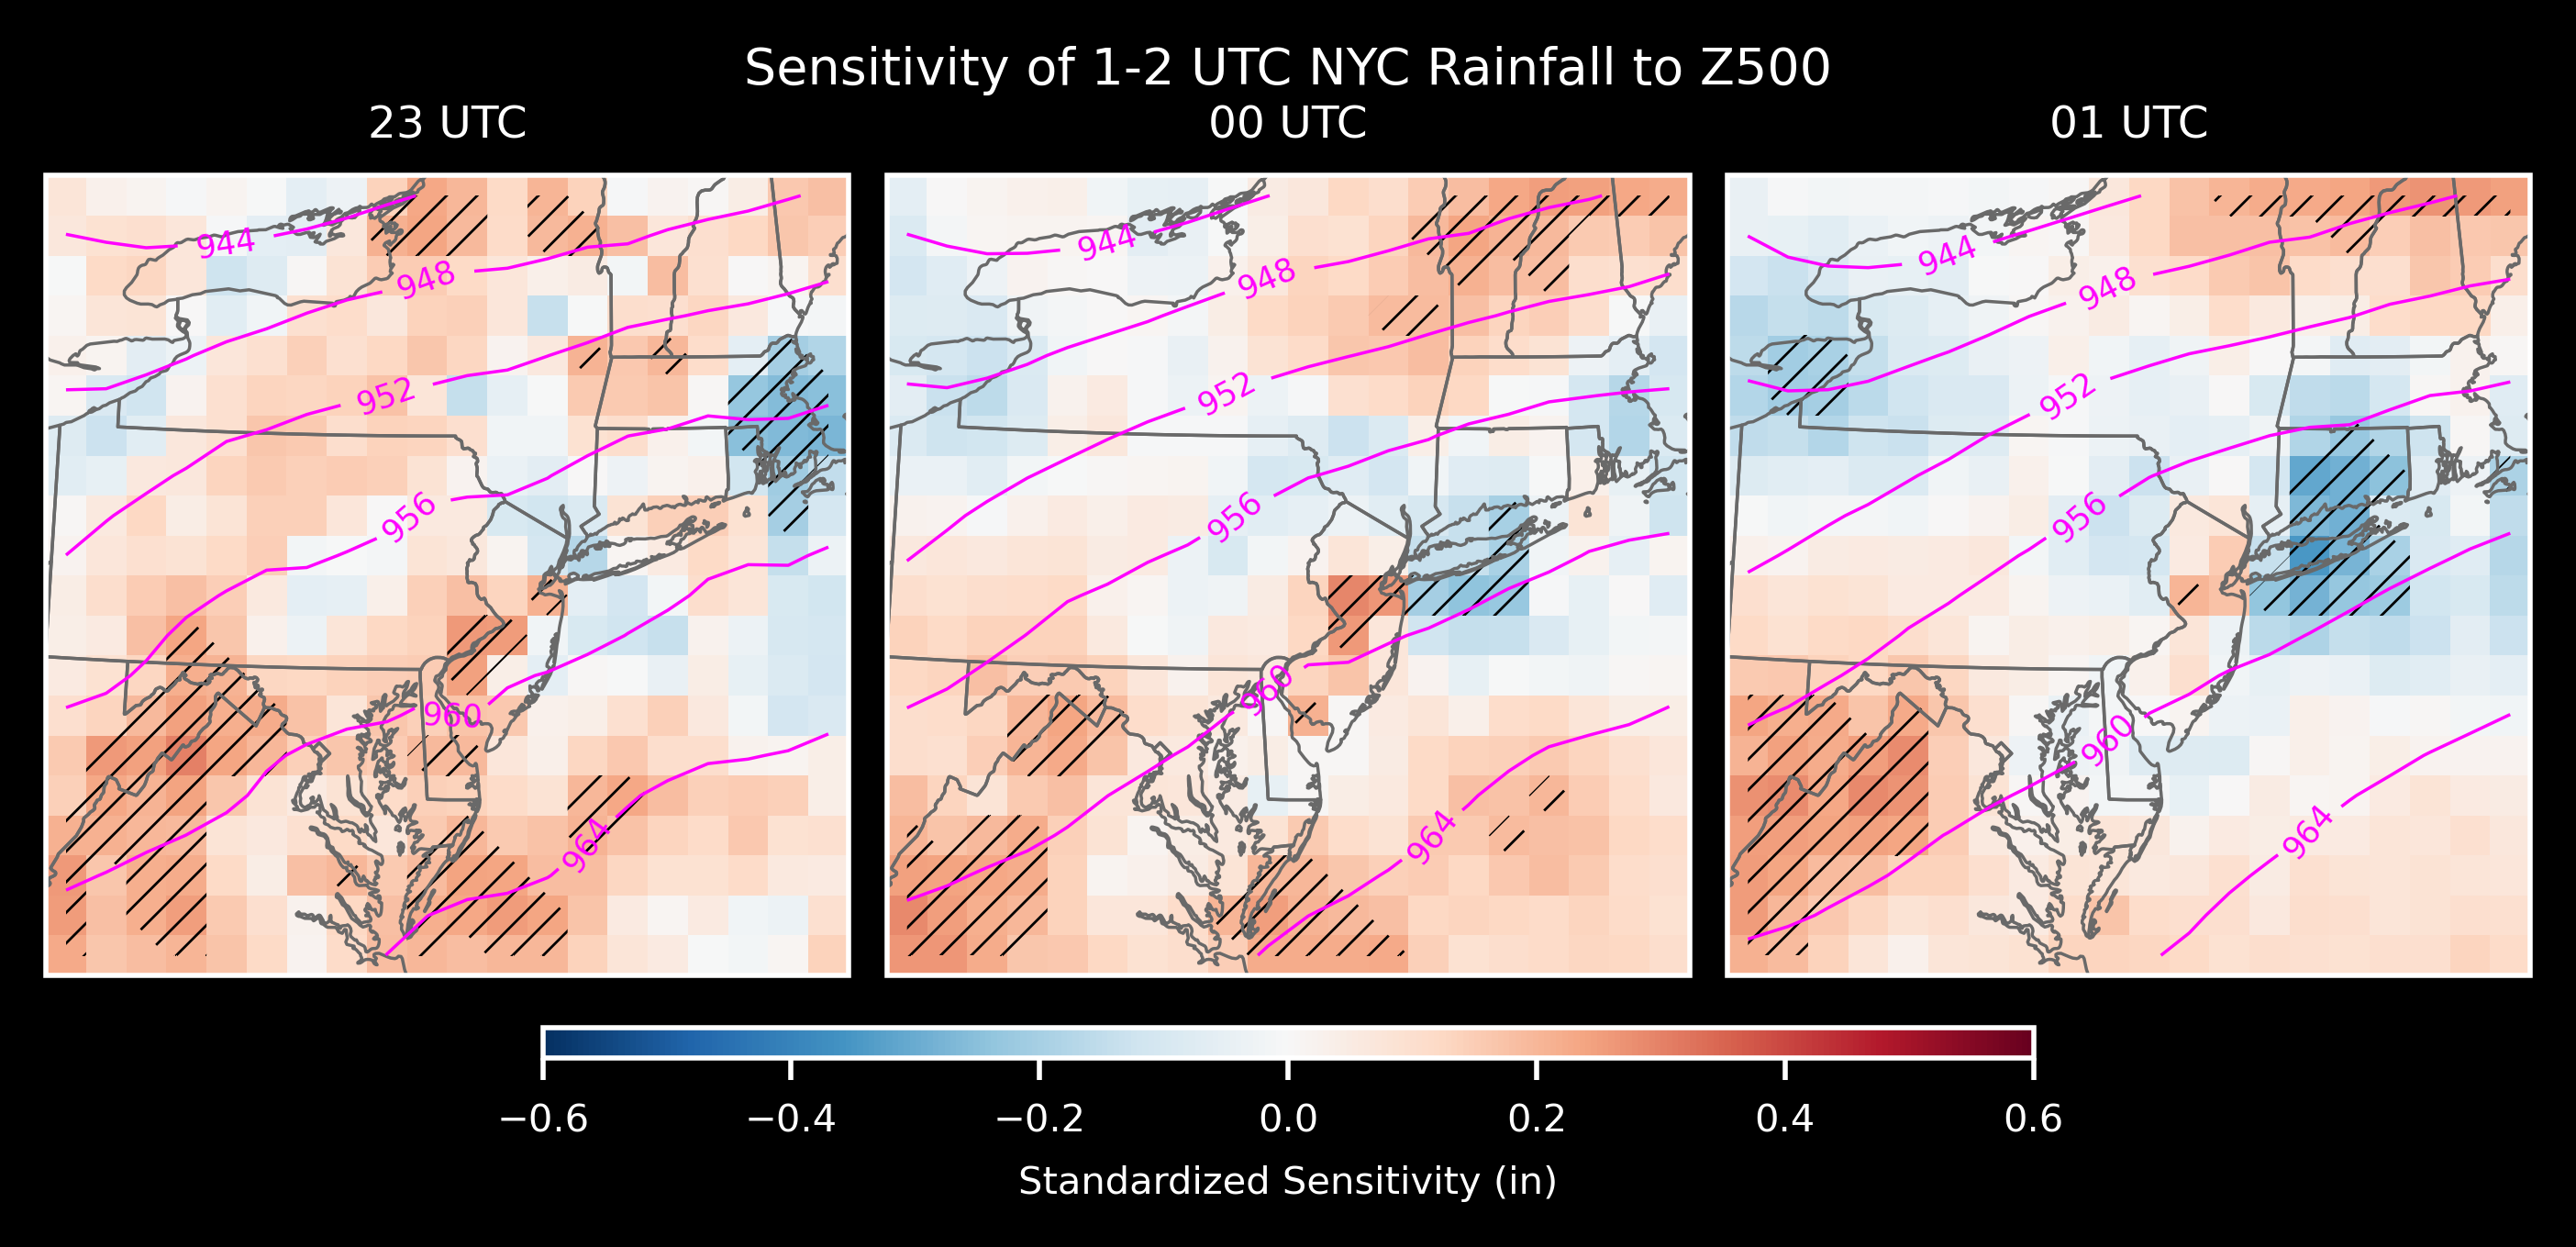

In [15]:
times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00", "2021-09-02 01:00:00"]
plt.rcParams["hatch.linewidth"] = 0.4
# Get data to plot
means = [gz.sel(time=t, pres=300).mean(dim=("ne", "init")).squeeze() for t in times]
data = [stan_sens_Z500.sel(time=t).squeeze() for t in times]
pdata = [pval_Z500.sel(time=t).squeeze() for t in times]
titles = ["23 UTC", "00 UTC", "01 UTC"]

# Increase the figure height to make more room vertically
fig, axes = plt.subplots(
    1,
    len(times),
    figsize=(5.5, 2.5),  # Increased height from 3 to 4
    dpi=500,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Adjust the suptitle position to be higher up
fig.suptitle(
    "Sensitivity of 1-2 UTC NYC Rainfall to Z500",
    fontsize=8,
    y=1.02,
)

# Plot spatial correlation
for i, ax in enumerate(axes):
    pc = ax.pcolormesh(
        coarse_lon,
        coarse_lat,
        data[i],  # .where(abs(pdata[i])<0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.6,
        vmax=0.6,
    )

    c = ax.contourf(
        coarse_lon,
        coarse_lat,
        (abs(pdata[i]) < 0.025),
        levels=[0, 0.5, 1],
        colors="none",
        hatches=("", "/////"),
        zorder=2,
        transform=ccrs.PlateCarree(),
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="dimgray", zorder=2)

    ax.set_title(titles[i], fontsize=7)

    # Add contours of the ensemble mean Z300
    c = ax.contour(
        coarse_lon,
        coarse_lat,
        means[i] / 10,
        zorder=3,
        transform=ccrs.PlateCarree(),
        linewidths=0.5,
        colors="magenta",
    )
    ax.clabel(c, inline=True, fontsize=5)


# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.05,
    aspect=50,
    shrink=0.6,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"Standardized Sensitivity (in)", fontsize=6)

plt.show()


### U300

In [20]:
raw_sens_U300 = xs.linslope(u_pres.sel(pres=300), rain12_aoi, dim=("ne", "init")).load()
stan_sens_U300 = raw_sens_U300 * u_pres.sel(pres=300).std(dim=("ne", "init"))
pval_U300 = xs.pearson_r_p_value(
    u_pres.sel(pres=300), rain12_aoi, dim=["ne", "init"]
).load()


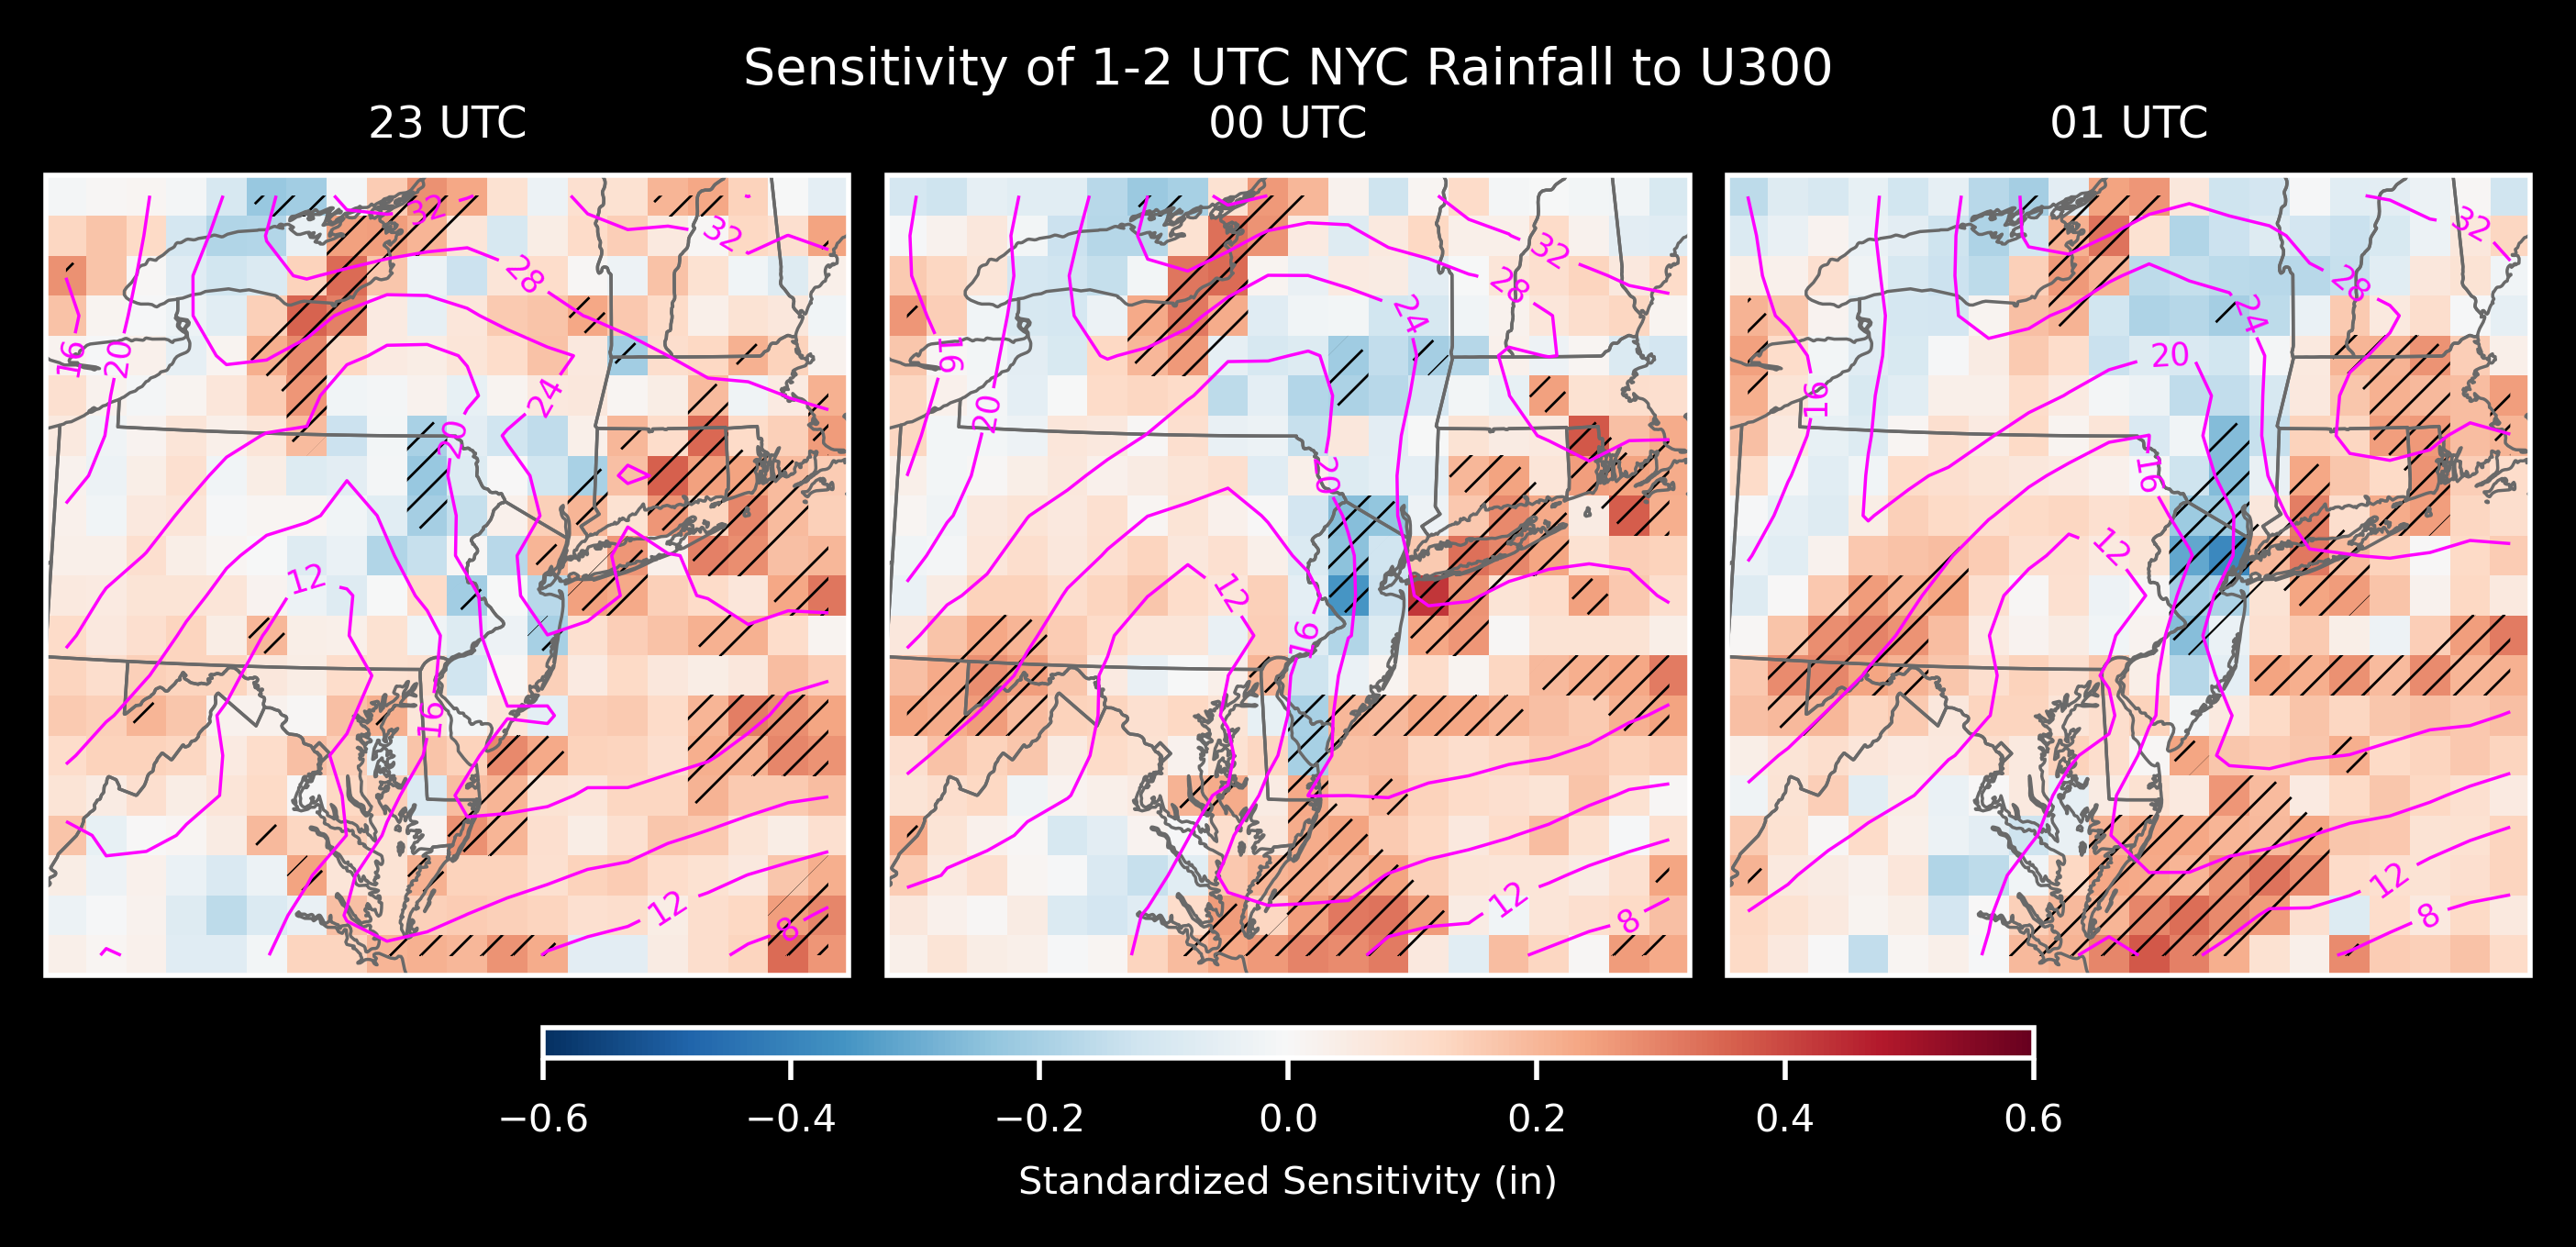

In [21]:
times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00", "2021-09-02 01:00:00"]
plt.rcParams["hatch.linewidth"] = 0.4
# Get data to plot
means = [u_pres.sel(time=t, pres=300).mean(dim=("ne", "init")).squeeze() for t in times]
data = [stan_sens_U300.sel(time=t).squeeze() for t in times]
pdata = [pval_U300.sel(time=t).squeeze() for t in times]
titles = ["23 UTC", "00 UTC", "01 UTC"]

# Increase the figure height to make more room vertically
fig, axes = plt.subplots(
    1,
    len(times),
    figsize=(5.5, 2.5),  # Increased height from 3 to 4
    dpi=500,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Adjust the suptitle position to be higher up
fig.suptitle(
    "Sensitivity of 1-2 UTC NYC Rainfall to U300",
    fontsize=8,
    y=1.02,
)

# Plot spatial correlation
for i, ax in enumerate(axes):
    pc = ax.pcolormesh(
        coarse_lon,
        coarse_lat,
        data[i],  # .where(abs(pdata[i])<0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.6,
        vmax=0.6,
    )

    c = ax.contourf(
        coarse_lon,
        coarse_lat,
        (abs(pdata[i]) < 0.025),
        levels=[0, 0.5, 1],
        colors="none",
        hatches=("", "/////"),
        zorder=2,
        transform=ccrs.PlateCarree(),
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="dimgray", zorder=2)

    ax.set_title(titles[i], fontsize=7)

    # Add contours of the ensemble mean Z300
    c = ax.contour(
        coarse_lon,
        coarse_lat,
        means[i],
        zorder=3,
        transform=ccrs.PlateCarree(),
        linewidths=0.5,
        colors="magenta",
    )
    ax.clabel(c, inline=True, fontsize=5)


# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.05,
    aspect=50,
    shrink=0.6,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"Standardized Sensitivity (in)", fontsize=6)

plt.show()


### Wind mag

In [22]:
wind_mag = np.sqrt(u_pres**2 + v_pres**2)

In [25]:
raw_sens_wind_mag = xs.linslope(
    wind_mag.sel(pres=300), rain12_aoi, dim=("ne", "init")
).load()
stan_sens_wind_mag = raw_sens_wind_mag * wind_mag.sel(pres=300).std(dim=("ne", "init"))
pval_wind_mag = xs.pearson_r_p_value(
    wind_mag.sel(pres=300), rain12_aoi, dim=["ne", "init"]
).load()


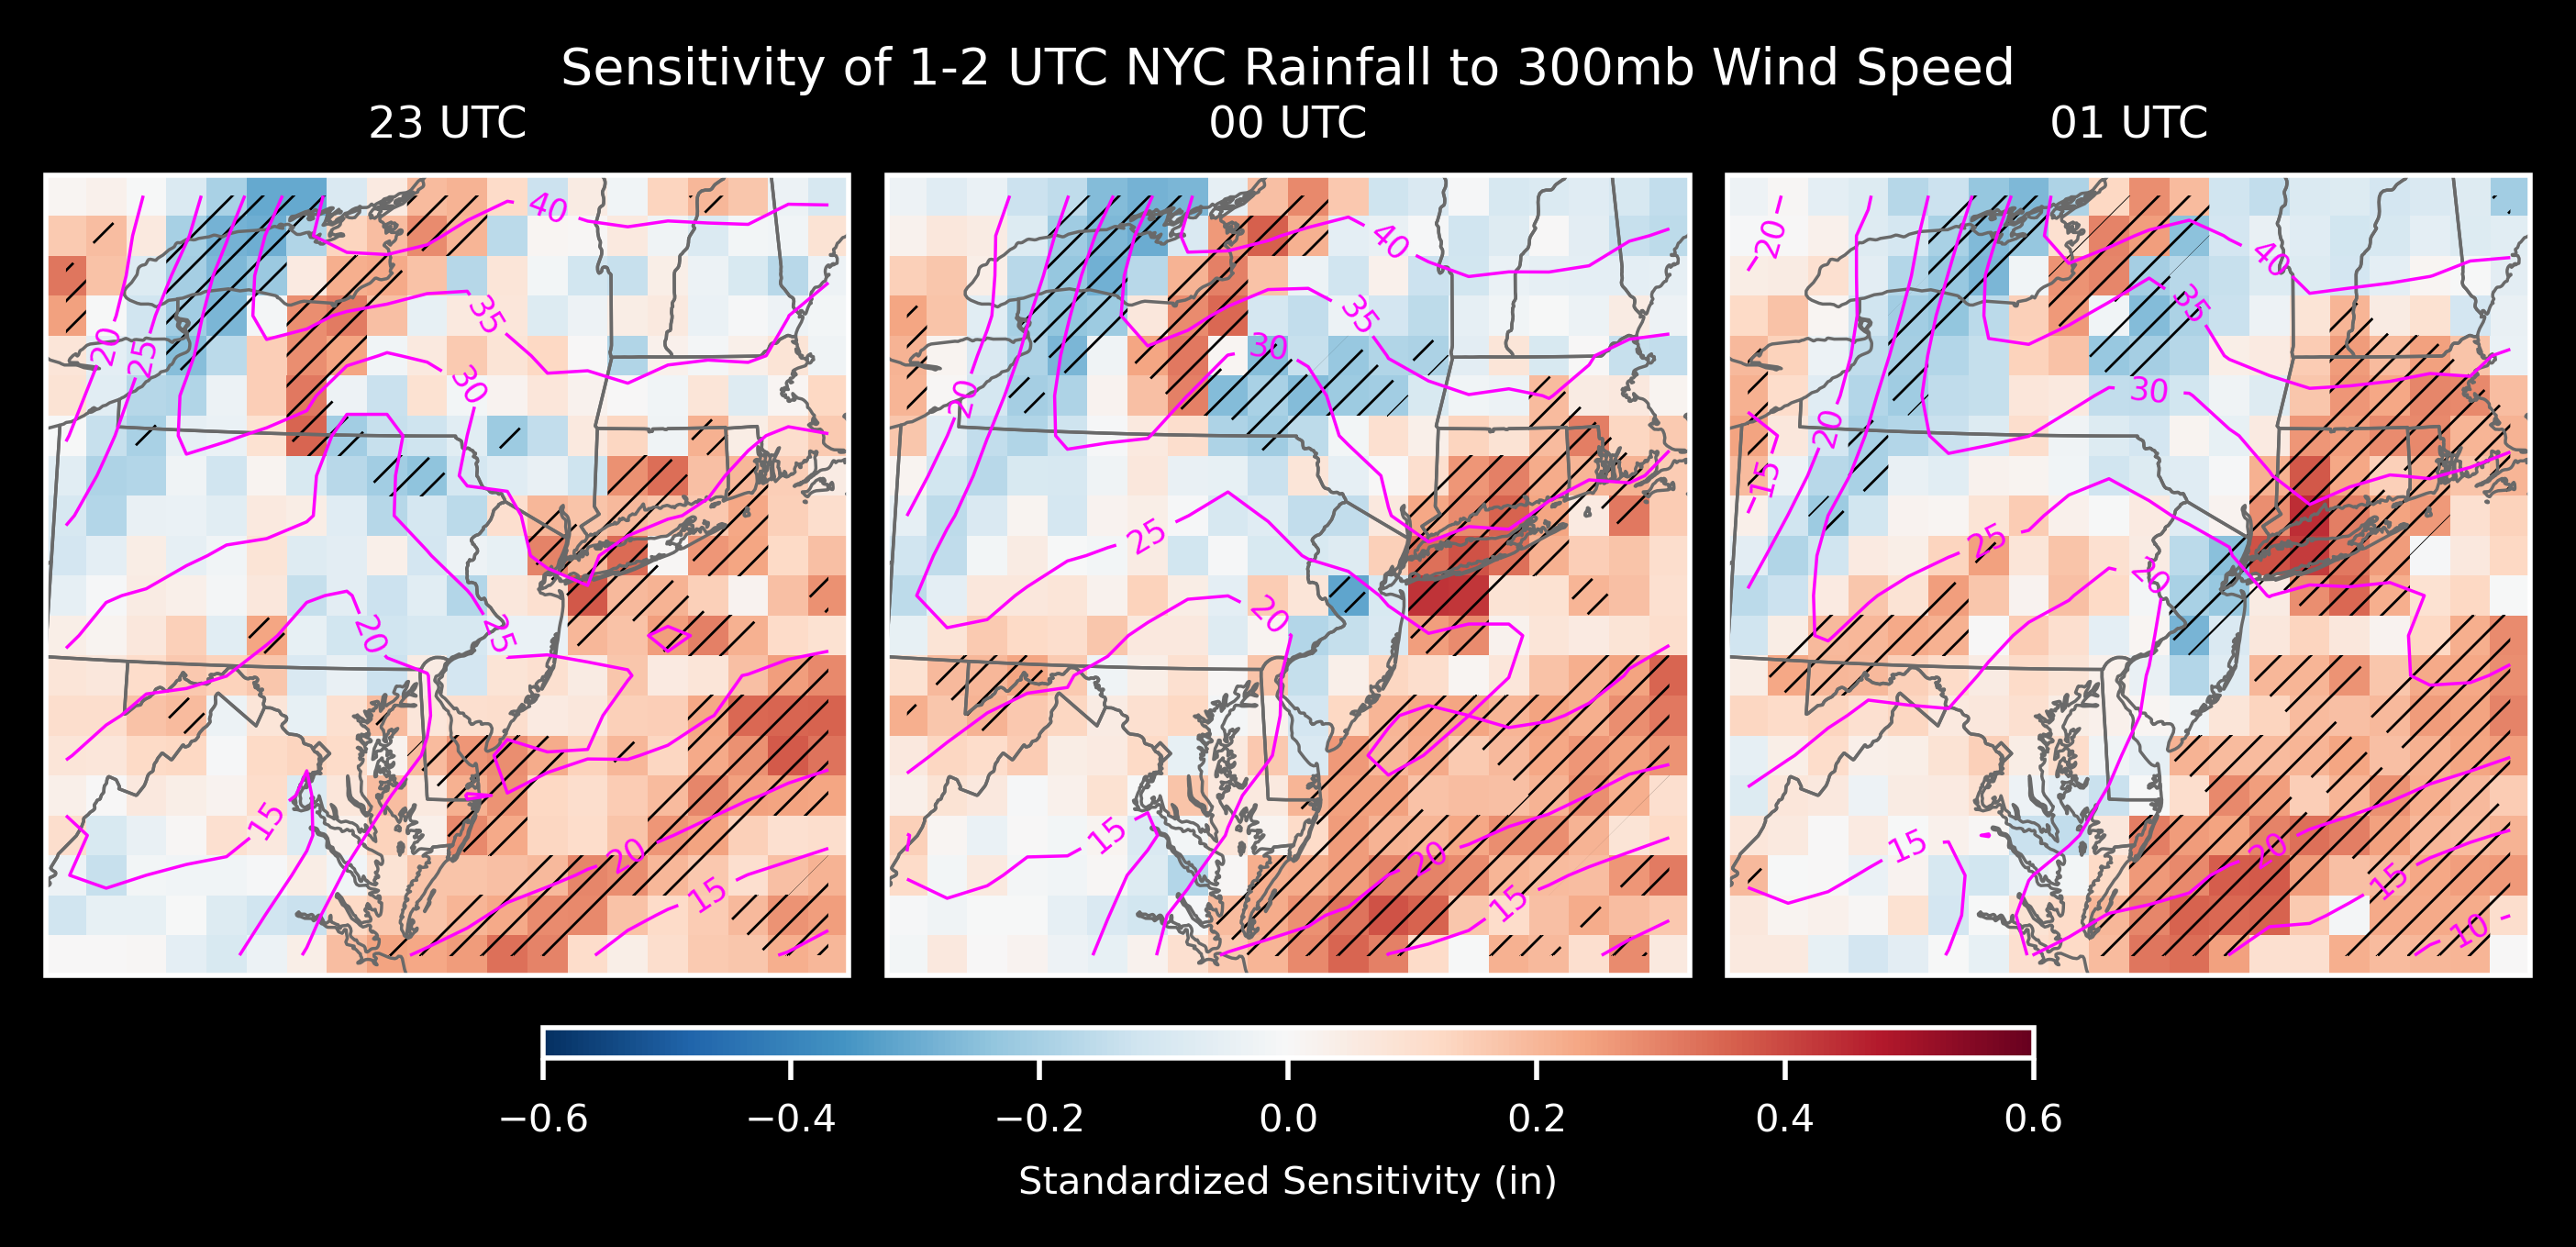

In [28]:
times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00", "2021-09-02 01:00:00"]
plt.rcParams["hatch.linewidth"] = 0.4
# Get data to plot
means = [wind_mag.sel(time=t, pres=300).mean(dim=("ne", "init")).squeeze() for t in times]
data = [stan_sens_wind_mag.sel(time=t).squeeze() for t in times]
pdata = [pval_wind_mag.sel(time=t).squeeze() for t in times]
titles = ["23 UTC", "00 UTC", "01 UTC"]

# Increase the figure height to make more room vertically
fig, axes = plt.subplots(
    1,
    len(times),
    figsize=(5.5, 2.5),  # Increased height from 3 to 4
    dpi=500,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

# Adjust the suptitle position to be higher up
fig.suptitle(
    "Sensitivity of 1-2 UTC NYC Rainfall to 300mb Wind Speed",
    fontsize=8,
    y=1.02,
)

# Plot spatial correlation
for i, ax in enumerate(axes):
    pc = ax.pcolormesh(
        coarse_lon,
        coarse_lat,
        data[i],  # .where(abs(pdata[i])<0.025),
        cmap="RdBu_r",
        zorder=1,
        transform=ccrs.PlateCarree(),
        vmin=-0.6,
        vmax=0.6,
    )

    c = ax.contourf(
        coarse_lon,
        coarse_lat,
        (abs(pdata[i]) < 0.025),
        levels=[0, 0.5, 1],
        colors="none",
        hatches=("", "/////"),
        zorder=2,
        transform=ccrs.PlateCarree(),
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="dimgray", zorder=2)

    ax.set_title(titles[i], fontsize=7)

    # Add contours of the ensemble mean Z300
    c = ax.contour(
        coarse_lon,
        coarse_lat,
        means[i],
        zorder=3,
        transform=ccrs.PlateCarree(),
        linewidths=0.5,
        colors="magenta",
    )
    ax.clabel(c, inline=True, fontsize=5)


# Create a shared horizontal colorbar below the plots
cb = fig.colorbar(
    pc,
    ax=axes,
    orientation="horizontal",
    pad=0.05,
    aspect=50,
    shrink=0.6,
)

cb.ax.tick_params(labelsize=6)
cb.set_label(r"Standardized Sensitivity (in)", fontsize=6)

plt.show()
